In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 26 17:17:34 2020

"""
import numpy as np
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d

1. Import data
   path_nadir and path_SWOTpass on OSMOSIS1 domain are imported:

In [2]:
#### SWOT DATA
# Make sure to put this script in the directory below (/data/OSMOSIS/) before you run it

domain_name = 'OSMOSIS1'
#addpath = '/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data'
#os.chdir(r'/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data/OSMOSIS')

# Name of the SWOT pass in data/*domain*/ directory
if domain_name == 'OSMOSIS1' :
    path_SWOTpass = 'BOOST-SWOT_SWOT_OSMOSIS_c02_p436.nc'
    path_nadir = 'BOOST-SWOT_J1_nadir_c05_p01.nc'
    # Plotting params
    max_range = 0.2 # Limit for colorbar (SSH in meters) for SSH
    max_range_diff = 0.1 # Limit for colorbar (SSH in meters) for SSH differences

2. Then SWOT and Nadir paths are downloaded

In [3]:
#### Download a SWOT path

roll_error_only = True

all_but_karin = False

with xr.open_dataset(path_SWOTpass, mask_and_scale=True) as (ds_SWOTpass):
    ntime = ds_SWOTpass.time.size
#ds_SWOTpass.info() # Dimension of the dataset
nc = ds_SWOTpass.nC.size
lon_swotpass = np.zeros([ntime, nc])
lon_swotpass [:,:] = ds_SWOTpass.lon
lon_swotpass = np.ma.masked_invalid(lon_swotpass)
lat_swotpass = np.zeros([ntime,nc])
lat_swotpass [:,:] = ds_SWOTpass.lat
lat_swotpass = np.ma.masked_invalid(lat_swotpass)
ssh_swotpass = np.zeros([ntime,nc])
if roll_error_only:
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err
elif all_but_karin:
   ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err
else: 
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_obs
ssh_swotpass = np.ma.masked_invalid(ssh_swotpass)
ssh_swotpass_truth = np.zeros([ntime, nc]) 
ssh_swotpass_truth[:, :] = ds_SWOTpass.ssh_model # ssh model
ssh_swotpass_truth = np.ma.masked_invalid(ssh_swotpass_truth)



In [4]:
#### Download NADIR path
with xr.open_dataset(path_nadir, mask_and_scale=True) as ds_nadirpass:
    ndtime = ds_nadirpass.time.size
lon_nadirpass = np.zeros([ndtime])
lon_nadirpass[:] = ds_nadirpass.lon
lat_nadirpass = np.zeros([ndtime])
lat_nadirpass[:] = ds_nadirpass.lat
x_al = np.zeros([ndtime])
x_al[:] = ds_nadirpass.x_al
ssh_nadir = np.zeros([ndtime])  
            
ssh_nadir[:] = ds_nadirpass.ssh_obs
ssh_nadir_truth = np.zeros([ndtime])  
ssh_nadir_truth[:] = ds_nadirpass.ssh_model


3. SSH along nadir track (x_al) for Nadir data

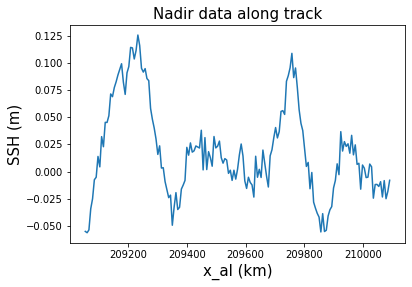

In [5]:
### SSH(m) vs Nadir along track (x_al) for Nadir data
plt.figure()
plt.plot(x_al,ssh_nadir)
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('Nadir data along track', fontsize=15)
plt.show()

# Interpolation of SWOT on Nadir

In [6]:
print(np.min(lon_swotpass))
print(np.max(lon_swotpass))
print(np.min(lat_swotpass))
print(np.max(lat_swotpass))

342.011232
348.569888
45.022436
54.962807999999995


nc,shape =  (52,) (597,)
ncx =  (597, 52)
nc_min =  4.5
nc_max =  5.499999998099983
ntime_min =  34.2
ntime_max =  34.79999999439883
dx,dy =  0.01960784310000019 0.001006711399995197


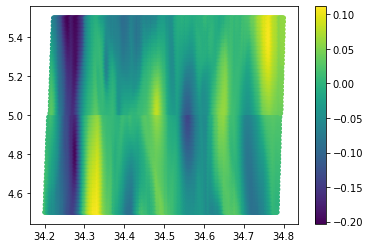

In [7]:
### creating a 2D grid

nc, ntime = 52,597
lat_swot = np.arange(45,55,0.196078431)*0.1
lon_swot = np.arange(342,348,0.010067114)*0.1
#nc = np.linspace(44,56,52)*0.1
#ntime = np.linspace(340,350,597)*0.1
dx, dy = lat_swot[1]-lat_swot[0], lon_swot[1]-lon_swot[0] # Not a regular grid
lon_swoty, lat_swotx = np.meshgrid(lat_swot,lon_swot)
plt.scatter(lat_swotx,lon_swoty,c=ssh_swotpass,s=15)
plt.colorbar()
print('nc,shape = ', lat_swot.shape,lat_swot.shape)
print('ncx = ',lat_swotx.shape)
print('nc_min = ',np.min(lat_swot))
print('nc_max = ',np.max(lat_swot))
print('ntime_min = ',np.min(lon_swot))
print('ntime_max = ',np.max(lon_swot))
print('dx,dy = ',dx,dy)

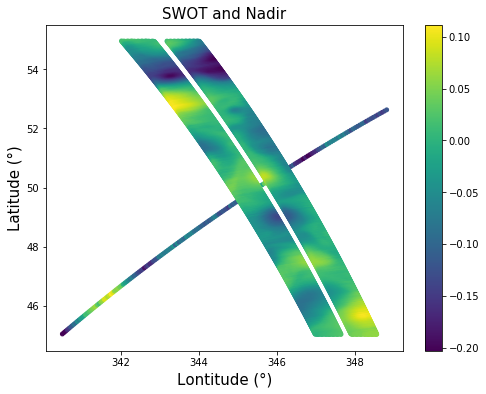

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.scatter(lon_swotpass, lat_swotpass,c=ssh_swotpass,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar()

In [9]:
swot2nadir_interp = interp2d(lat_swot, lon_swot, ssh_swotpass)# but RectBivariteSpline is better if the grid are regular
#swot2nadir_interp = RectBivariateSpline(nc, ntime, ssh_swotpass)
swot2nadir_interp

# Nadir 

In [10]:
print(np.min(lon_nadirpass))
print(np.max(lon_nadirpass))
print(np.min(lat_nadirpass))
print(np.max(lat_nadirpass))

340.49232
348.82464
45.04036
52.6293


In [11]:
swot_on_nadir = swot2nadir_interp(lon_nadirpass, lat_nadirpass)
print(swot_on_nadir.shape)
print(np.max(swot_on_nadir))
print(np.min(swot_on_nadir))
#plt.plot(lon_nadirpass, lat_nadirpass)

(169, 169)
0.05937
0.05937


In [12]:
swot_on_nadir = np.diag(swot_on_nadir)
print(swot_on_nadir)
np.all(swot_on_nadir==0.05937) # All elements in the matrix are equal

[0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.

True

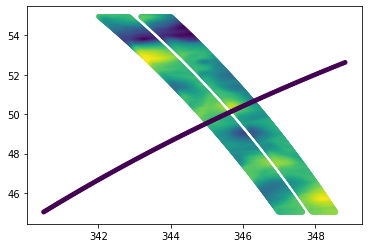

In [13]:
plt.scatter(lon_swotpass, lat_swotpass,c=ssh_swotpass,s=15)
plt.scatter(lon_nadirpass, lat_nadirpass, c=swot_on_nadir, s=15)

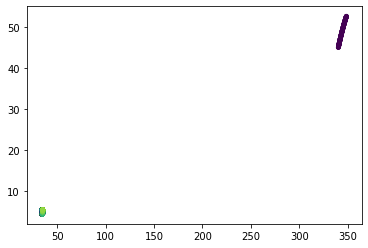

In [14]:
plt.scatter(ncx,ntimey,c=ssh_swotpass, s=15)
#plt.contour(ncx,ntimey,ssh_swotpass)
#plt.plot(lon_nadirpass, lat_nadirpass)
plt.scatter(lon_nadirpass, lat_nadirpass, c=swot_on_nadir, s=15)